---
title: The Perceptron
author: Omar Armbruster
date: '2025-03-31'
image: "image.png"
description: "It's all fun and games until you Percept-wrong"
format: html
execute:
    message: false
    warning: false
---

# Abstract
The perceptron algorithm is the simplest model of a neural network, designed to take multiple inputs and output a single output representing the class of the input in a binary classification problem. The model works by iteratively updating a set of weights until a loss of zero is achieved, indicating perfect classification accuracy. We implement the perceptron algorithm and test it on linearly separable, non-linearly separable, and multi-dimensional linearly separable data to test its capabilities. We also implement a minibatch version of the algorithm, which examines multiple rows of the data at each step and updates the weights using their average gradient. Using these experiments, we can determine the strengths and weaknesses of the perceptron algorithm, which we can use to inform improvements we make when developing further algorithms. 

# Introduction
Several of my blog posts have examined the machine's capability to learn, but until now, none have examined the machine's ability to perceive. Yet, such wonders are possible through the perceptron model, which has been developed through algorithmic mad-science in the image of a neuron. This blog post examines our own implementation of the monstrous perceptron whose capabilities range from binary classification to binary classification. Through a series of experiments we can test the limits of our creation. Come, let us peer into the dark and twisted mind of the perceptron [here](https://github.com/omar-armbruster/omar-armbruster.github.io/blob/main/posts/perceptron/perceptron.py)... if you dare!

## The Gradient Function
Looking into the mind of our complex creature, we can find the `grad()` function, which calculates a gradient with which to update the existing weights. For each iteration of our algorithm, we pass a single row of the input data and its corresponding label into the algorithm. The algorithm calculates the gradients as such $$gradient = -\mathbf{1}[s_i(2y_i - 1) < 0](2y_i - 1)\mathbf{x_i}$$ where $i$ represents the index of the row of data used and $s_i$ represents the score of that row of data such that $$s_i = \langle w \,, \mathbf{x_i}\rangle$$ with $w$ representing the existing weights. At each step of the algorithm, the perceptron randomly selects an observation from the data and updates the weights if the observation is misclassified. Since our classifier selects groups based on if the score of a given observation is positive or negative, we can check if an observation is misclassified using the expression $[s_i(2y_i - 1)<0]$. This expression converts each label $y$ from values of $0$ and $1$ to $-1$ and $1$. This means that observations with negative scores should have a label of $-1$ and observations with positive scores should have a label of $1$. Because the product of two real numbers with opposite signs is always negative and the product of two real numbers with the same signs is positive, we will find that all correctly classified observations will have positive products when multiplying their scores and labels while misclassified observations will be negative. Thus, be evaluating the boolean expression above, we will multiply our gradient by $0$ for correctly classified observations (no change is made to the weights) and $1$ for misclassified observations. Our gradient is then determined by the values of the observation, which are added to the current weights if the real label is positive ($2y_i - 1$ evaluates to $1$) and subtracted if the real label is negative.

# Awakening the Perceptron 

In [19]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In order to perform our experiments, we need to define some functions. The first we implement is `perceptron_data()`, which generates a dataset where the first half of the points are classified as $0$ and the second half are classified as $1$. Unique observations are generated using a normal distribution with a selected noise parameter. We can also alter the number of dimensions used in the data, which will later allow us to demonstrate the perceptron's full abilities.

We also define `plot_perceptron_data()`, which allows us to visualize our data before classifying it. This is important for determining if the data are **linearly separable**, meaning whether or not we can achieve a perfect classification accuracy by drawing a straight line between the clusters. In the dataset below, we can see that we can in fact separate the clusters perfectly. We will later examine the perceptron's strengths and weaknesses when dealing with data that are not linearly separable.

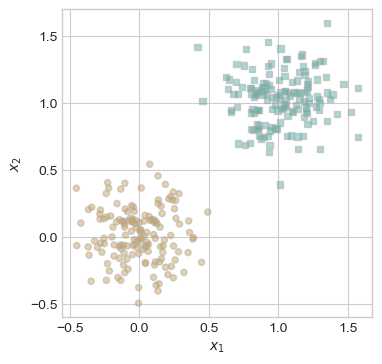

In [20]:
## Perceptron data and plotting functions sourced from Phil Chodrow lecture notes
#| fig-cap: '300 data points in the 2d plane, each of which has one of two labels.'
#| fig-cap-location: margin
#| label: fig-scatter
#| code-fold: true

import torch
from matplotlib import pyplot as plt
import numpy as np
plt.style.use('seaborn-v0_8-whitegrid')


def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)    
    return X, y

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
X, y = perceptron_data()
plot_perceptron_data(X, y, ax)

The heart of our perceptron algorithm is defined here whome I have affectionately named Percy (short for perceptron). We define the `Perceptron()` class and optimizer, which will be used to make updates to and store the weights. The true learning occurs in the while loop, where the perceptron continues to iterate through the data until a loss of $0$ (indicating no misclassifications) is obtained. At each step, the perceptron randomly selects observation $i$ and then calls the step function, which updates the weights based on observation $i$ using the gradient function we discussed above.

In [242]:
# Perceptron training loop sourced from Phil Chodow lecture notes

def Percy(X, y):
    p = Perceptron() 
    opt = PerceptronOptimizer(p)

    loss = 1.0

    # for keeping track of loss values
    loss_vec = []

    n = X.size()[0]

    while loss > 0: # Continues training loop until perfect loss is achieved. Will never terminate if data are not linearly separable!
        
        # Records loss values
        loss = p.loss(X, y) 
        loss_vec.append(loss)
        
        # pick a random data point
        i = torch.randint(n, size = (1,))
        x_i = X[[i],:]
        y_i = y[i]
        
        # perform a perceptron update using the random data point
        opt.step(x_i, y_i)
    return p, loss_vec

We feed the linearly separable data we generated earlier to Percy, who masterfully learns the optimal weights that allow us to achieve a loss of $0$ after $20$ iterations. We plot the loss below to show how each change to the weights impacts the loss. It is important to note that the loss does not decrease steadily, and at some points actually increases before reaching $0$. This can be attributed to the randomness of each step, as many of the randomly selected observations will already be classified correctly (leading to no change in the weights or loss) and some of the updates to the weights will overshoot the optimal change to the weights.

tensor(0.) 20


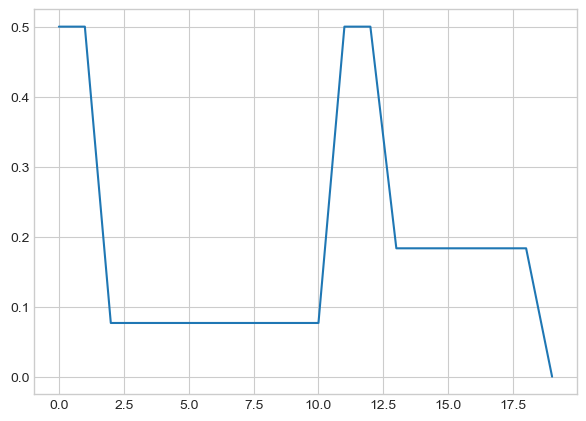

In [243]:
torch.manual_seed(14)
p, loss_vec = Percy(X,y)
print(loss_vec[-1], len(loss_vec))
plt.plot(loss_vec)

# Experiments
Now that we've implemented our perceptron algorithm, we can begin our experiments, which will showcase the strengths, weaknesses, and possible variations of the perceptron algorithm. Our goal is to experiment with three datasets: linearly separable data, non-linearly separable data, and higher-dimensional data. 

We can analyze the perceptron's performance by examining how the weights are updated at each iteration as well as how the loss changes at each iteration. In order to do this, we need to make some slight modifications to our perceptron Percy. Much like a child with Life360, we track each of Percy's steps by recording both the previous and updated weights. In order to prevent Percy from running amuck and getting lost, we implement a `max_iter` argument, which will stop the training loop after a specified number of iterations. This will be important for our experiment with the non-linearly separable data. We also record the randomly selected indexes so we can track which point was used to update the weights. With these changes, we implement the `Percy_with_life360()` function. 

We also implement the `progress_loss()` function, which trims our list of losses to only contain loss values for iterations where updates to the weights were made.

In [169]:
def Percy_with_life360(X, y, max_iter = 1000):
    p = Perceptron() 
    opt = PerceptronOptimizer(p)
    loss = 1.0
    # for keeping track of loss and weight values
    loss_vec = []
    old_ws = []
    new_ws = []
    idxs = []
    n = X.size()[0]
    iter = 0
    while loss > 0 and iter < max_iter: #Only proceeds if there are still misclassifications and if we have not exceeded the iteration cutoff.
        iter += 1  
        # pick a random data point
        i = torch.randint(n, size = (1,))
        idxs.append(i)
        x_i = X[[i],:]
        y_i = y[i]
        local_loss = p.loss(x_i, y_i).item()
        if local_loss > 0: # Only perform following operations if the point we selected is misclasssified
           #Save previous weights for plotting progress on misclassified iterations
            old_w = torch.clone(p.w)
            old_ws.append(old_w)
            # perform a perceptron update using the random data point we selected
            opt.step(x_i, y_i) 
            new_w = torch.clone(p.w)
            new_ws.append(new_w)
        # Calculate loss after possible step and append to our list
        loss = p.loss(X, y) 
        loss_vec.append(loss)
    return p, np.array(loss_vec), np.vstack((old_ws, new_ws)).T, np.array(idxs)

def progress_loss(loss):
    '''
    Removes steps from a list of losses where no progress was made. Returns the shortened list and the indexes from the original list 
    '''
    idxs = np.where(np.abs(np.diff(loss)) > 0)[0] + 1
    idxs = np.insert(idxs, 0, 0)
    return loss[idxs], idxs
    

We define the `draw_line()` function to draw lines representing the classification boundary for each set of weights. We then use this in the `plot_progress()` function, which plots the data used in our experiment and visualizes 6 steps in the training loop where changes to the weights are made. We expect to see a gradual improvement in the classification boundary at each step until we (hopefully) achieve a perfect classification accuracy.

In [219]:
### Figure code adapted from Phil Chodrow Perceptron Notes


def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

def plot_progress(X, y, ws, loss, idxs, axarr):
    markers = ["o", ","]
    marker_map = {-1 : 0, 1 : 1}
    s_loss, steps = progress_loss(loss)
    idx = idxs[steps]
    if len(s_loss) > axarr.size:
        intermediate = steps[1:-1][torch.randint(len(steps) - 2, (axarr.size - 2,))]
        steps = np.insert(np.insert(intermediate, 0, 0), 5, steps[-1])
        s_loss = loss[steps]
        idx = idxs[steps]
    for i, l in enumerate(s_loss):
        ax = ax = axarr.ravel()[i]
        plot_perceptron_data(X, y, ax,)
        draw_line(ws[i,0], x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        draw_line(ws[i,1], x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[idx[i],0],X[idx[i],1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[2*(y[i].item())-1]])
        ax.set_title(f"loss = {l:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        ax.text(1, 1.8, 'Step: {}'.format(steps[i] + 1))

## 1) Linearly Separable Data
We feed the same data from our initial trial into our new and improved perceptron and use the returned benchmark data to visualize the changes in the weights at each step where the dotted line represents the previous classification boundary and the solid line represents the updated boundary based on the selected point (shaded in black). The boundary improves at each step and while the loss does not always decrease, we can see that the orientation of the line continuously imrpoves indicating some sort of progress towards the optimal solution.  

c:\Users\omara\.conda\envs\ml451\lib\site-packages\numpy\core\shape_base.py:121: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Users\omara\.conda\envs\ml451\lib\site-packages\numpy\core\shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
C:\Users\omara\AppData\Local\Temp\ipykernel_25180\3115190900.py:31: Fu

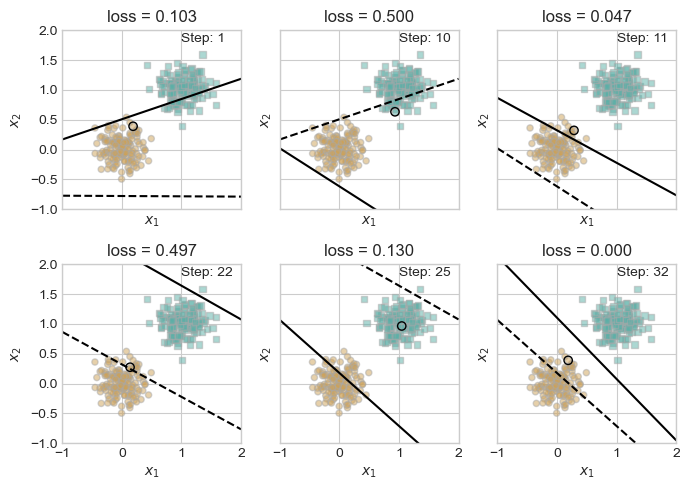

In [220]:
torch.manual_seed(14)
p, loss, ws, idxs = Percy_with_life360(X, y)
# # set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
plot_progress(X, y, ws, loss, idxs, axarr)
plt.tight_layout()

We also plot the loss for the entire training loop, which demonstrates that there is not always a direct improvement, largely because no changes are made any time that a correctly classified point is selected.

Text(0.5, 0, 'Iteration')

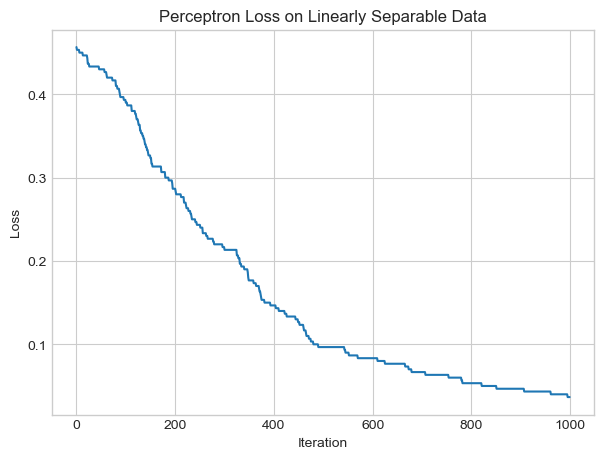

In [244]:
plt.plot(loss)
plt.title('Perceptron Loss on Linearly Separable Data')
plt.ylabel('Loss')
plt.xlabel('Iteration')

## 2) Non-linearly Separable Data
Now for a harder problem. Up to this point, there has always been a line that exists that could divide the two clusters with perfect accuracy. With this new data, this is no longer the case. We generate this data in the same way as the linearly separable data but increase the gaussian noise from $0.2$ to $0.4$, which causes the points from the two clusters to overlap.

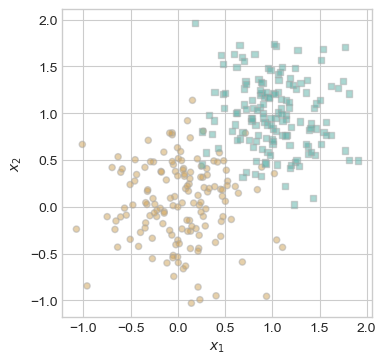

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
uX, uy = perceptron_data(300, 0.4, p_dims=2)
plot_perceptron_data(uX, uy, ax)

When visualizing Percy's progress through the training loop, we notice that it never achieves a loss of $0$. As we discussed earlier, this is because no solution exists that would achieve a perfect loss. Letting the perceptron algorithm run on this data will eventually achieve an optimal, but never perfect solution to the classification problem. In this case, we can achieve a very small loss, but it will never be $0$. Because of the way the perceptron algorithm is designed, the training loop will continue indefinitely for this data, so it is important that we implemented the stopping condition which stops the training loop if there is no convergence after $1000$ iterations.

c:\Users\omara\.conda\envs\ml451\lib\site-packages\numpy\core\shape_base.py:121: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Users\omara\.conda\envs\ml451\lib\site-packages\numpy\core\shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
C:\Users\omara\AppData\Local\Temp\ipykernel_25180\3115190900.py:31: Fu

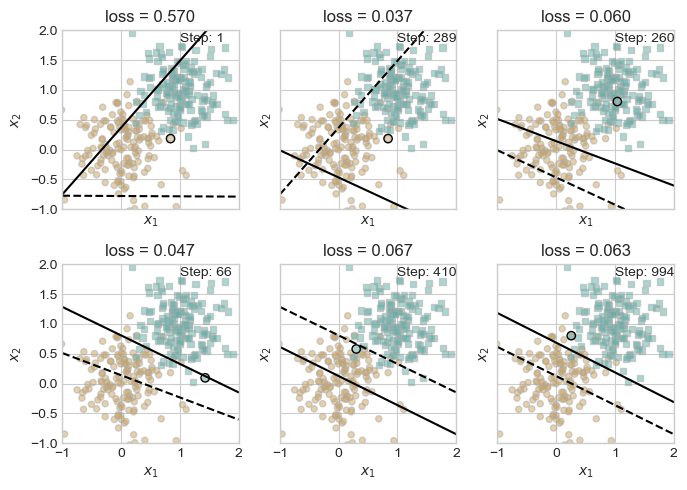

In [246]:
torch.manual_seed(14)
p, loss, ws, idxs = Percy_with_life360(uX, uy)
# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
plot_progress(uX, uy, ws, loss, idxs, axarr)
plt.tight_layout()

When we plot the loss, we can notice large rises and drops in the loss where each update to the weights are made. While we are able to get a fairly low loss (indicating high classification accuracy), we are required to cut off the training loop early since we know that the loop will never terminate. Because the loss does not converge, we can notice that the loss actually increases before terminating, revealing a weakness of the perceptron algorithm. Assigning an arbitrary cutoff like we did will cause the algorithm to cease at exactly $1000$ iterations. This means we run the risk of stopping the algorithm in the middle of one of the large rises, meaning we don't always get the lowest possible loss.

Text(0, 0.5, 'Loss')

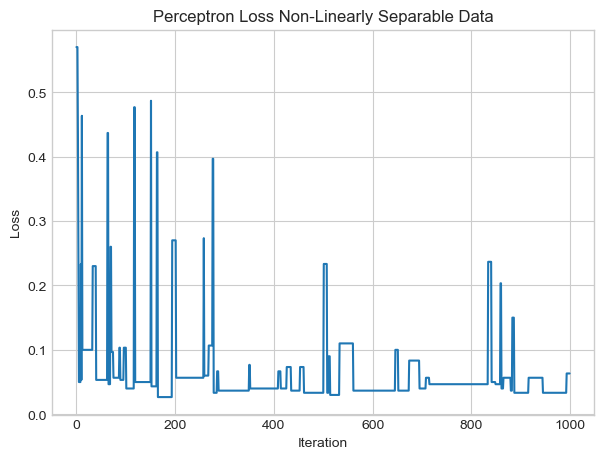

In [248]:
plt.plot(loss)
plt.title('Perceptron Loss Non-Linearly Separable Data')
plt.xlabel('Iteration')
plt.ylabel('Loss')

## 3) 8-Dimensional Data
Our final dataset contains eight dimensions instead of two, meaning we cannot visualize the change in the classification boundary as we did for the other datasets. However, we can still monitor the loss. When we do, we notice that the loss converges, indicating that the algorithm does in fact work for multi-dimensional data and that this particular dataset is linearly separable. Nice!

C:\Users\omara\AppData\Local\Temp\ipykernel_25180\3115190900.py:31: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return p, np.array(loss_vec), np.vstack((old_ws, new_ws)).T, np.array(idxs)
C:\Users\omara\AppData\Local\Temp\ipykernel_25180\3115190900.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return p, np.array(loss_vec), np.vstack((old_ws, new_ws)).T, np.

Text(0, 0.5, 'Loss')

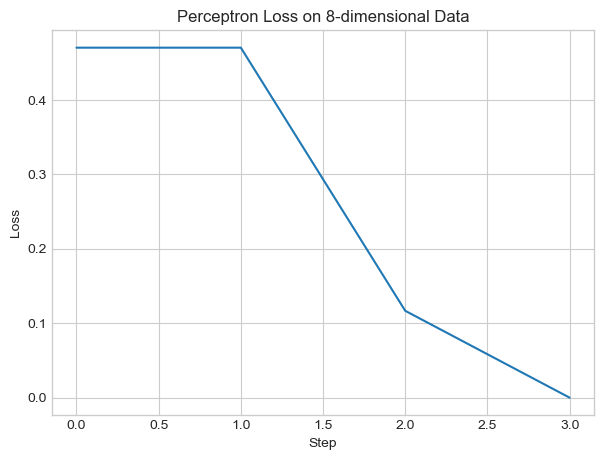

In [249]:
torch.manual_seed(16)
mX, my = perceptron_data(300, 0.2, p_dims=8)
p, loss, ws, idxs = Percy_with_life360(mX, my)
plt.plot(loss)
plt.title('Perceptron Loss on 8-dimensional Data')
plt.xlabel('Step')
plt.ylabel('Loss')

# The Minibatch Perceptron
We can further augment the perceptron algorithm by adding batch adjustments to the weights. What this means is that instead of selecting a single observation at each step, we can select multiple and use the average of their gradient scores to update the weights. This could possibly provide a speed up to the algorithm, requiring fewer iterations to select the points needed to update the weights sufficiently. We make a slight modification to our algorithm, which selects $k$ points at each iteration to compute the gradients of. We also define the `alpha` parameter, representing the learning rate. By adjusting this, we can determine how highly we weight the gradient at each iteration. A higher learning rate will weight the gradient higher, causing larger adjustments. This could result in fewer iterations needed for convergance but is also likely to cause the algorithm to overshoot the weights and miss the optimal weights. A low learning rate will require more iterations but is much less likely to overshoot the optimal weights.

In [250]:
def Percy_with_multitasking(X, y, k = 1, alpha = 1, max_iter = 1000):
    p = Perceptron() 
    opt = PerceptronOptimizer(p)
    loss = 1.0
    # for keeping track of loss and weight values
    loss_vec = []
    old_ws = []
    new_ws = []
    idxs = []
    n = X.size()[0]
    iter = 0
    while loss > 0 and iter < max_iter: #Only proceeds if there are still misclassifications and if we have not exceeded the iteration cutoff.
        iter += 1  


        # pick a batch of random data points
        ix = torch.randperm(X.size(0))[:k]
        x_i = X[ix, :]
        y_i = y[ix]
        idxs.append(ix)

        local_loss = p.loss(x_i, y_i).item()
        if local_loss > 0: # Only perform following operations if the point we selected is misclasssified
           #Save previous weights for plotting progress on misclassified iterations
            old_w = torch.clone(p.w)
            old_ws.append(old_w)
            # perform a perceptron update using the random data point we selected
            opt.step(x_i, y_i, alpha) 
            new_w = torch.clone(p.w)
            new_ws.append(new_w)
        # Calculate loss after possible step and append to our list
        loss = p.loss(X, y) 
        loss_vec.append(loss)
    return p, np.array(loss_vec), np.vstack((old_ws, new_ws)).T, np.array(idxs)

When we select $k = 1$, $1$ point is selected at each iteration, meaning the algorithm behaves exactly as it did before. 

C:\Users\omara\AppData\Local\Temp\ipykernel_25180\766313144.py:34: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return p, np.array(loss_vec), np.vstack((old_ws, new_ws)).T, np.array(idxs)
C:\Users\omara\AppData\Local\Temp\ipykernel_25180\766313144.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return p, np.array(loss_vec), np.vstack((old_ws, new_ws)).T, np.ar

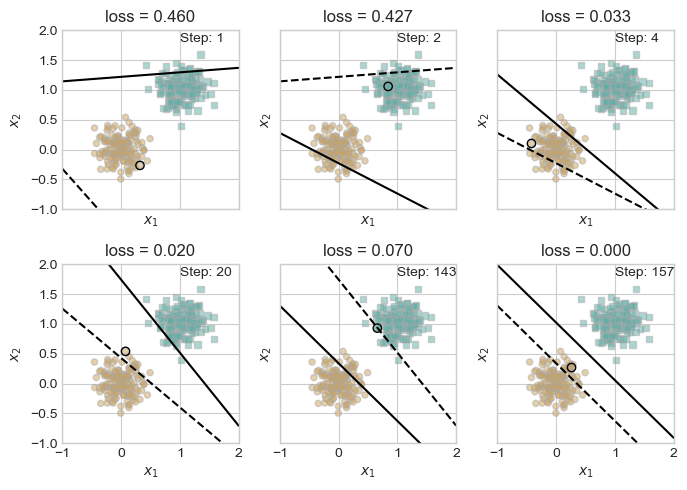

In [251]:
torch.manual_seed(27)
p, loss, ws, idxs = Percy_with_multitasking(X, y, k = 1)
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
plot_progress(X, y, ws, loss, idxs, axarr)
plt.tight_layout()


For the case where $k = 10$, we can see that $10$ observations are selected at each iteration, causing the loss to steadily decrease until it converges. We can also note that it only takes $7$ iterations for the loss to converge as opposed to the $k = 1$ algorithm, which took $157$ iterations.

C:\Users\omara\AppData\Local\Temp\ipykernel_25180\766313144.py:34: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return p, np.array(loss_vec), np.vstack((old_ws, new_ws)).T, np.array(idxs)
C:\Users\omara\AppData\Local\Temp\ipykernel_25180\766313144.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return p, np.array(loss_vec), np.vstack((old_ws, new_ws)).T, np.ar

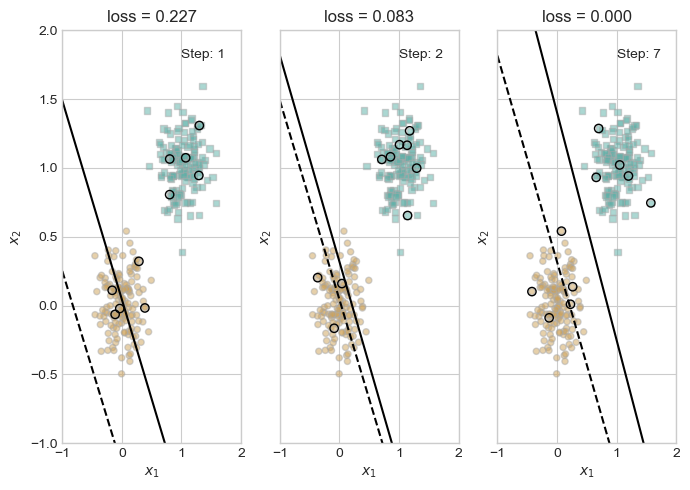

In [232]:
torch.manual_seed(20)
p, loss, ws, idxs = Percy_with_multitasking(X, y, k = 10)
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(1, 3, sharex = True, sharey = True)
plot_progress(X, y, ws, loss, idxs, axarr)
plt.tight_layout()

Finally, we can test the algorithm with $k = 300$, which means that the entire dataset will be selected at each iteration. We apply this algorithm to the non-linearly separable data and find that the loss actually converges, despite not being able to find a solution earlier. This is because uh....................

C:\Users\omara\AppData\Local\Temp\ipykernel_25180\766313144.py:34: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return p, np.array(loss_vec), np.vstack((old_ws, new_ws)).T, np.array(idxs)
C:\Users\omara\AppData\Local\Temp\ipykernel_25180\766313144.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return p, np.array(loss_vec), np.vstack((old_ws, new_ws)).T, np.ar

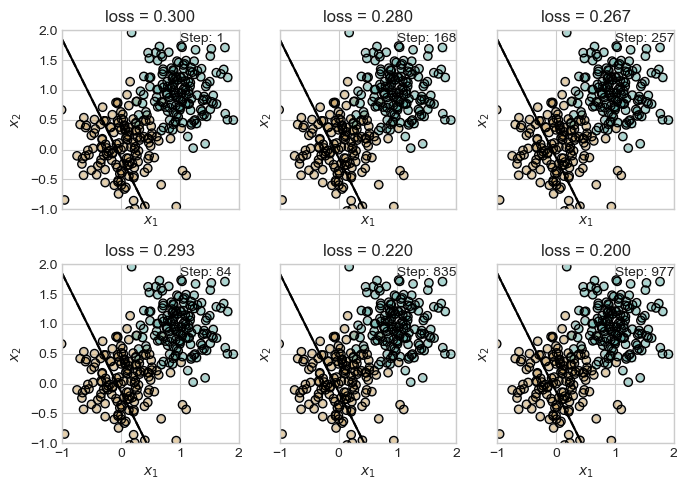

In [252]:
# torch.manual_seed(20)
p, loss, ws, idxs = Percy_with_multitasking(uX, uy, k = 300, alpha = 0.001, max_iter=1000)
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
plot_progress(uX, uy, ws, loss, idxs, axarr)
plt.tight_layout()

# Musings on Runtime Complexity
It takes a while

# Conclusion
The machine perceived. This leaves us with important questions like "Is the perceptron an autobot or a decepticon?" and "What would happen if we strung several of these neurons together?" Wow that's deep.